## Deep Learning with PyTorch**

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing, and radiology. Here we build two deep learning architectures to classify images.





# Setup Skeleton



## PyTorch Installation

In [ ]:
!pip install torch torchvision

In [ ]:
import shutil
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(torch.__version__)
print(device)

1.8.1+cu101
cuda:0


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
A_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', '1')
H_FOLDER=os.path.join(A_FOLDER, '2')
os.makedirs(H_FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

file_path = os.path.join(H_FOLDER, "data.zip")
if not os.path.isfile(file_path):
    gdd.download_file_from_google_drive(file_id='1A-dYo1ba1mjTrnH6xjzYrg_fO_GxHjvN',
                                      dest_path=file_path)

##  Filter out corrupt and nonexistent images 


In [ ]:
from PIL import Image

# TODO: Implement this function to filter out invalid images
def check_corrupt(filename):
  format = Image.open(filename).format
  is_valid = (format != 'JPEG')
  return is_valid

In [ ]:
# Check all images in the train file for validity and write the valid ones to train_path
shutil.unpack_archive(file_path)

base_path = '/content/indoorCVPR_09/Images'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'test/')
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

correct_file_count_train = 0
train_file = open("/content/TrainImages.txt", "r") 
for file in train_file:
    image_path = os.path.join(base_path, file.rstrip('\n'))
    dest_folder = os.path.join(train_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(train_path, file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_train += 1
    dest = shutil.move(image_path, dest_path)  

correct_file_count_test = 0
test_file = open("/content/TestImages.txt", "r") 
for file in test_file:
    image_path = os.path.join(base_path,file.rstrip('\n'))
    dest_folder = os.path.join(test_path, file.split('/')[0])
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(test_path,file.rstrip('\n'))
    if os.path.getsize(image_path) == 0 or check_corrupt(image_path):
        continue
    correct_file_count_test += 1
    dest = shutil.move(image_path, dest_path)

## Build a dataset class 


In [ ]:
from torchvision import datasets, transforms

transform1 = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

In [ ]:
from torchvision import datasets, transforms

train_dataset = datasets.ImageFolder(root = train_path, transform = transform1 )
test_dataset = datasets.ImageFolder(root = test_path, transform = transform1 )

## Visualize images from the dataset

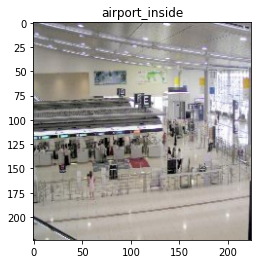

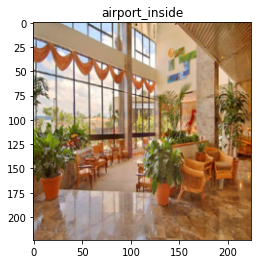

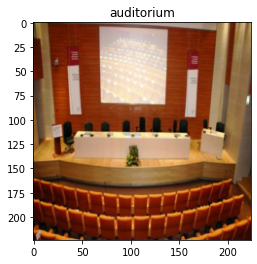

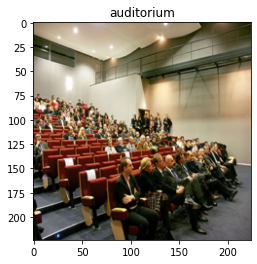

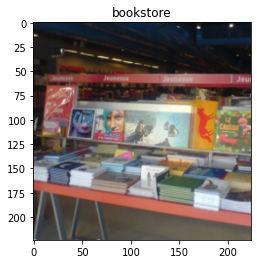

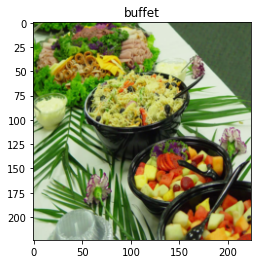

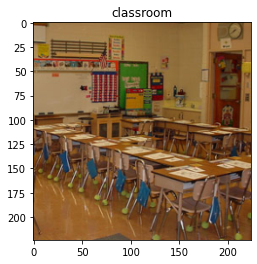

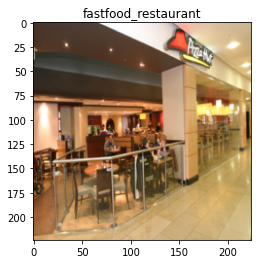

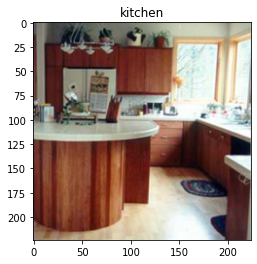

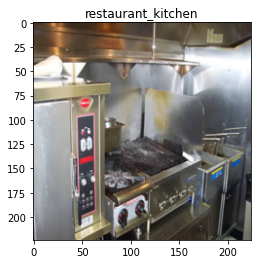

In [ ]:
# Visualize 10 images in the dataset with their labels
%matplotlib inline

import matplotlib.pyplot as plt

sample_idxs = [1, 3, 213, 224, 567, 779, 1052, 2000, 3000, 4444]
for sample_idx in sample_idxs:
    data, label = train_dataset[sample_idx]
    plt.imshow(data.permute(1, 2, 0))
    plt.title(train_dataset.classes[label])
    plt.show()

We can see that these images are now having the same size due to our transformation above, and some examples can be really hard to classify - like the airport inside class!

## Class frequency distributions 

In [ ]:

def create_frequency_dict(train_dataset):
  freq_dist = {}
  for i in train_dataset.classes:
    freq_dist[i] = 0

  for i in train_dataset:
    data, label = i
    picture_class = train_dataset.classes[label]
    freq_dist[picture_class] += 1
  
  return freq_dist

scene_frequency_dict = create_frequency_dict(train_dataset)
print(scene_frequency_dict)

{'airport_inside': 80, 'artstudio': 80, 'auditorium': 82, 'bakery': 81, 'bar': 82, 'bathroom': 82, 'bedroom': 79, 'bookstore': 80, 'bowling': 80, 'buffet': 79, 'casino': 80, 'children_room': 82, 'church_inside': 81, 'classroom': 82, 'cloister': 80, 'closet': 81, 'clothingstore': 82, 'computerroom': 80, 'concert_hall': 80, 'corridor': 79, 'deli': 81, 'dentaloffice': 79, 'dining_room': 82, 'elevator': 79, 'fastfood_restaurant': 80, 'florist': 81, 'gameroom': 80, 'garage': 81, 'greenhouse': 80, 'grocerystore': 79, 'gym': 80, 'hairsalon': 79, 'hospitalroom': 80, 'inside_bus': 77, 'inside_subway': 79, 'jewelleryshop': 78, 'kindergarden': 79, 'kitchen': 79, 'laboratorywet': 78, 'laundromat': 77, 'library': 79, 'livingroom': 80, 'lobby': 80, 'locker_room': 79, 'mall': 80, 'meeting_room': 78, 'movietheater': 80, 'museum': 77, 'nursery': 79, 'office': 79, 'operating_room': 81, 'pantry': 80, 'poolinside': 79, 'prisoncell': 80, 'restaurant': 80, 'restaurant_kitchen': 77, 'shoeshop': 80, 'stairsca

## Create Dataloader objects 


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

# Section 2: Let's build classifiers!

We have the data we need to train a scene classifier. We will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## Logical Logistic Regression - Baseline Model



### Model Definition

First define the loss function for our model.

This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

In [ ]:
# TODO: Define a PyTorch Cross Entropy Loss object, name it 'criterion', 
# this loss function does a log-softmax first to get the probabilities
# and then computes the Negative Log Likelihood loss
criterion = nn.CrossEntropyLoss()

In [157]:
# Define and initialize a logistic regression model, save it in a variable called `lr_model`
lr_model = nn.Sequential(nn.Linear(150528, len(train_dataset.classes)))

In [158]:
lr_model.train()

Sequential(
  (0): Linear(in_features=150528, out_features=67, bias=True)
)

In [159]:
lr_input_dim = 150528     # TODO: use your input dimension for the Logistic Regression model here
summary(lr_model.to(device), (1, lr_input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 67]      10,085,443
Total params: 10,085,443
Trainable params: 10,085,443
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.00
Params size (MB): 38.47
Estimated Total Size (MB): 39.05
----------------------------------------------------------------


## OPTIMIZER



In [161]:
lr_model.parameters()

<generator object Module.parameters at 0x7f92ac13a7d0>

In [162]:
# TODO: define the optimizer object for Logistic Regression
import torch.optim as optim
lr_optimizer = optim.Adam(lr_model.parameters(), lr = 0.00001)

In [ ]:
#epochs = 10
#loss_list = []
#accuracy_list = []
#counter = []
#for i in range(epochs):
  #accurate_count = 0
  #inaccurate_count = 0
  #epoch_loss = []
  #for data, labels in train_loader:
    # flatten data
    #flat_data = torch.flatten(data, 1).to(device)

    # zero grad optimizer
    #lr_optimizer.zero_grad()

    # calculate prediction
    #prediction = lr_model(flat_data)

    # calculate loss and loss backward
    #loss = criterion(prediction, labels.cuda())
    #loss.backward()
    #epoch_loss.append(loss.item())
    
    # optimizer step
    #lr_optimizer.step()

    # calculate the number of accurate prediction
    #prediction = torch.argmax(prediction, 1)
    #index = 0
    #for i in prediction:
      #if i == labels[index]:
        #accurate_count += 1
      #else:
        #inaccurate_count +=1
      #index += 1
  
  #count = (accurate_count, inaccurate_count)
  #counter.append(count)
  #accuracy = accurate_count/(accurate_count + inaccurate_count)
  #loss_val = sum(epoch_loss)/len(epoch_loss)

  #accuracy_list.append(accuracy)
  #loss_list.append(loss_val)

## Train Model

In [163]:
def train_model(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.train()
    model.to(device)
    
    # TODO: Implement your training loop as specified in the description
    loss_list = []
    accuracy_list = []
    for i in range(epochs):
      accurate_count = 0
      inaccurate_count = 0
      epoch_loss = []
      for data, labels in train_loader:
        # flatten data
        flat_data = torch.flatten(data, 1).to(device)

        # zero grad optimizer
        optimizer.zero_grad()

        # calculate prediction
        prediction = model(flat_data)

        # calculate loss and loss backward
        loss = criterion(prediction, labels.cuda())
        loss.backward()
        epoch_loss.append(loss.item())
    
        # optimizer step
        optimizer.step()

        # calculate the number of accurate prediction
        prediction = torch.argmax(prediction, 1)
        index = 0
        for i in prediction:
          if i == labels[index]:
            accurate_count += 1
          else:
            inaccurate_count +=1
          index += 1
    
      accuracy = accurate_count/(accurate_count + inaccurate_count)
      loss_val = sum(epoch_loss)/len(epoch_loss)

      accuracy_list.append(accuracy)
      loss_list.append(loss_val)

    final_training_accuracy = accuracy_list[epochs- 1]    
    final_training_loss = loss_list[epochs - 1]     
    return final_training_loss, final_training_accuracy, loss_list, accuracy_list

In [ ]:
loss_list = []
accuracy_list = []
lr_training_loss, lr_training_accuracy, loss_list, accuracy_list = train_model(lr_model, lr_optimizer, criterion)

print("Logistic Regression - the training loss is ", str(lr_training_loss))
print("Logistic Regression - the training accuracy is ", str(lr_training_accuracy))

Logistic Regression - the training loss is  2.999836073664134
Logistic Regression - the training accuracy is  0.3039325842696629


In [ ]:
accuracy_list

[0.030711610486891385,
 0.0750936329588015,
 0.11254681647940075,
 0.14119850187265917,
 0.1700374531835206,
 0.19138576779026217,
 0.22397003745318353,
 0.2451310861423221,
 0.2786516853932584,
 0.3039325842696629]

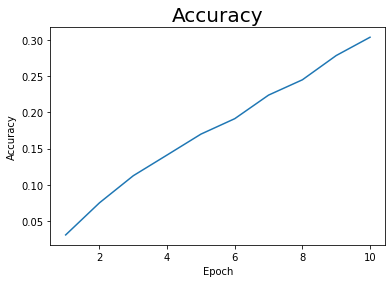

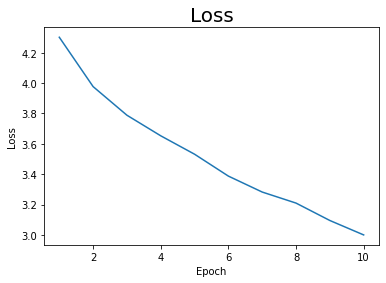

In [ ]:
import matplotlib
from matplotlib import pyplot as plt

from matplotlib.pyplot import subplots, show

fig, ax = subplots()
ax.plot(range(1, 11), accuracy_list)
ax.set_title('Accuracy', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
show()

fig, ax = subplots()
ax.plot(range(1, 11), loss_list)
ax.set_title('Loss', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
show()

In [ ]:
def test_model(model, criterion):
    model.eval()

    accurate_count = 0
    inaccurate_count = 0
    epoch_loss = []

    for data, labels in test_loader:
      # flatten data
      flat_data = torch.flatten(data, 1).to(device)

      # calculate prediction
      prediction = model(flat_data)

      # calculate loss and loss backward
      loss = criterion(prediction, labels.cuda())
      loss.backward()
      epoch_loss.append(loss.item())

      # calculate the number of accurate prediction
      prediction = torch.argmax(prediction, 1)
      index = 0
      for i in prediction:
        if i == labels[index]:
          accurate_count += 1
        else:
          inaccurate_count +=1
        index += 1

    testing_loss = sum(epoch_loss)/len(epoch_loss)      
    testing_accuracy = accurate_count/(accurate_count + inaccurate_count)    
    return  testing_loss, testing_accuracy

In [ ]:
lr_testing_loss, lr_testing_accuracy = test_model(lr_model, criterion)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  4.1246660625724285
Logistic Regression - the testing accuracy is  0.07432432432432433


# Implementing FNNs

In [ ]:

fnn_input_dim = 150528
num_hidden_1 = 1000
num_hidden_2 = 200
num_hidden_3 = 100
output_size = len(train_dataset.classes)

fnn_model = nn.Sequential(
    nn.Linear(fnn_input_dim, num_hidden_1),
    nn.ReLU(),
    nn.Linear(num_hidden_1, num_hidden_2),
    nn.ReLU(),
    nn.Linear(num_hidden_2, num_hidden_3),
    nn.ReLU(),
    nn.Linear(num_hidden_3, output_size),
    nn.ReLU(),
)

In [ ]:
fnn_input_dim = 150528             # TODO: use your input dimension for the FNN model here
summary(fnn_model.to(device), (1, fnn_input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1000]     150,529,000
              ReLU-2              [-1, 1, 1000]               0
            Linear-3               [-1, 1, 200]         200,200
              ReLU-4               [-1, 1, 200]               0
            Linear-5               [-1, 1, 100]          20,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                [-1, 1, 67]           6,767
              ReLU-8                [-1, 1, 67]               0
Total params: 150,756,067
Trainable params: 150,756,067
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.02
Params size (MB): 575.09
Estimated Total Size (MB): 575.68
----------------------------------------------------------------


In [ ]:

loss_list = []
accuracy_list = []
fnn_epochs = 20              # TODO: set the number of epochs
fnn_optimizer = optim.SGD(fnn_model.parameters(), lr = 0.01)    # TODO: initialize the optimizer
fnn_training_loss, fnn_training_accuracy, loss_list, accuracy_list = train_model(fnn_model, fnn_optimizer, criterion, fnn_epochs)

print("Feedforward Neural Network - the training loss is ", str(fnn_training_loss))
print("Feedforward Neural Network - the training accuracy is ", str(fnn_training_accuracy))

Feedforward Neural Network - the training loss is  3.3249450386641266
Feedforward Neural Network - the training accuracy is  0.21310861423220973


In [ ]:
accuracy_list

[0.014044943820224719,
 0.019662921348314606,
 0.02397003745318352,
 0.03464419475655431,
 0.04531835205992509,
 0.049812734082397,
 0.052434456928838954,
 0.05711610486891386,
 0.06348314606741573,
 0.06741573033707865,
 0.07116104868913857,
 0.07846441947565543,
 0.08651685393258426,
 0.08689138576779026,
 0.10093632958801498,
 0.10037453183520599,
 0.11254681647940075,
 0.12078651685393259,
 0.1290262172284644,
 0.13651685393258428,
 0.14119850187265917,
 0.1458801498127341,
 0.15861423220973783,
 0.1659176029962547,
 0.17359550561797754,
 0.18239700374531836,
 0.19176029962546817,
 0.19644194756554306,
 0.20973782771535582,
 0.21310861423220973]

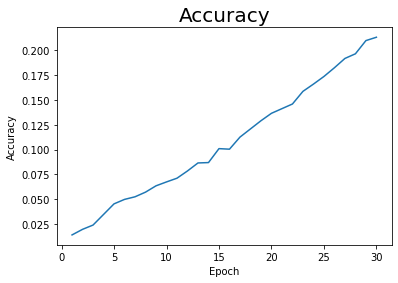

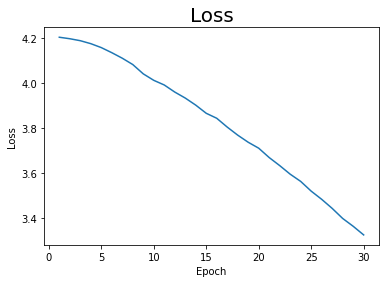

In [ ]:
from matplotlib import pyplot as plt

from matplotlib.pyplot import subplots, show

fig, ax = subplots()
ax.plot(range(1, len(accuracy_list)+1), accuracy_list)
ax.set_title('Accuracy', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
show()

fig, ax = subplots()
ax.plot(range(1, len(loss_list) +1), loss_list)
ax.set_title('Loss', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
show()

In [ ]:
# Compute performance on the test set using the test_model function created before
fnn_testing_loss, fnn_testing_accuracy = test_model(fnn_model, criterion)

print("Feedforward Neural Network - the testing loss is ", str(fnn_testing_loss))
print("Feedforward Neural Network - the testing accuracy is ", str(fnn_testing_accuracy))

RuntimeError: ignored

## CNN 

We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions


In [ ]:
features = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 3),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size = 3, stride = 2)
)

cnn_input_dim = 64 * 110 * 110
num_hidden_1 = 1000
num_hidden_2 = 200
num_hidden_3 = 100
output_size = len(train_dataset.classes)

flat = 
classifier = nn.Sequential(
    nn.Linear(cnn_input_dim, num_hidden_1),
    nn.ReLU(),
    nn.Linear(num_hidden_1, num_hidden_2),
    nn.ReLU(),
     nn.Linear(num_hidden_2, num_hidden_3),
    nn.ReLU(),
    nn.Linear(num_hidden_3, output_size),
    nn.ReLU()
)

for data, label in train_loader:
 print(features(data).shape)

torch.Size([32, 64, 110, 110])
torch.Size([32, 64, 110, 110])
torch.Size([32, 64, 110, 110])
torch.Size([32, 64, 110, 110])
torch.Size([32, 64, 110, 110])
torch.Size([32, 64, 110, 110])


KeyboardInterrupt: ignored

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 3),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
        )

        cnn_input_dim = 64 * 110 * 110
        num_hidden_1 = 100
        num_hidden_2 = 100
        num_hidden_3 = 100
        output_size = len(train_dataset.classes)

        self.classifier = nn.Sequential(
          nn.Linear(cnn_input_dim, num_hidden_1),
          nn.ReLU(),
          nn.Linear(num_hidden_1, num_hidden_2),
          nn.ReLU(),
          nn.Linear(num_hidden_2, num_hidden_3),
          nn.ReLU(),
          nn.Linear(num_hidden_3, output_size),
          nn.ReLU(),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

    return x

cnn_model = Net()

Let's take a look at the structure of the defined CNN model.

In [ ]:
summary(cnn_model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
         MaxPool2d-3         [-1, 64, 110, 110]               0
            Linear-4                  [-1, 100]      77,440,100
              ReLU-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 67]           6,767
             ReLU-11                   [-1, 67]               0
Total params: 77,468,859
Trainable params: 77,468,859
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

In [ ]:
# Define a training function which trains the passed model for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(model, optimizer, criterion, epochs=10):
    for child in model.children():
      if hasattr(child, 'reset_parameters'):
        child.reset_parameters()
    model.to(device)
    model.train()

    loss_list = []
    accuracy_list = []
    for i in range(epochs):
      accurate_count = 0
      inaccurate_count = 0
      epoch_loss = []
      for data, labels in train_loader:
        data = data.cuda()
        labels = labels.cuda()

        # zero grad optimizer
        optimizer.zero_grad()

        # calculate prediction
        prediction = model(data)

        # calculate loss and loss backward
        loss = criterion(prediction, labels.cuda())
        loss.backward()
        epoch_loss.append(loss.item())
    
        # optimizer step
        optimizer.step()

        # calculate the number of accurate prediction
        prediction = torch.argmax(prediction, 1)
        index = 0
        for i in prediction:
          if i == labels[index]:
            accurate_count += 1
          else:
            inaccurate_count +=1
          index += 1
    
      accuracy = accurate_count/(accurate_count + inaccurate_count)
      loss_val = sum(epoch_loss)/len(epoch_loss)

      accuracy_list.append(accuracy)
      loss_list.append(loss_val)

    final_training_accuracy = accuracy_list[epochs- 1]     # TODO: Set this to final training accuracy
    final_training_loss = loss_list[epochs - 1]      # TODO: Set this to final testing accuracy
    return final_training_loss, final_training_accuracy, loss_list, accuracy_list

In [145]:
import torch.optim as optim

loss_list = []
accuracy_list = []
cnn_epochs = 10                      
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr = 0.0001)         # TODO: initialize the optimizer
cnn_training_loss, cnn_training_accuracy, loss_list, accuracy_list = train_cnn(cnn_model, cnn_optimizer, criterion, cnn_epochs)

print("Convolutional Neural Network - the training loss is ", str(cnn_training_loss))
print("Convolutional Neural Network - the training accuracy is ", str(cnn_training_accuracy))

Convolutional Neural Network - the training loss is  2.2042130710122114
Convolutional Neural Network - the training accuracy is  0.5382022471910113


In [148]:
loss_list

[3.1448492375676502,
 3.0541254232029713,
 2.9432685232448006,
 2.869604079309338,
 2.749333180353313,
 2.648957801436236,
 2.546501105417035,
 2.4470914809289805,
 2.3133692655734674,
 2.2042130710122114]

In [149]:
accuracy_list

[0.28239700374531834,
 0.3061797752808989,
 0.33632958801498125,
 0.35262172284644194,
 0.39176029962546816,
 0.4157303370786517,
 0.4460674157303371,
 0.4749063670411985,
 0.5116104868913858,
 0.5382022471910113]

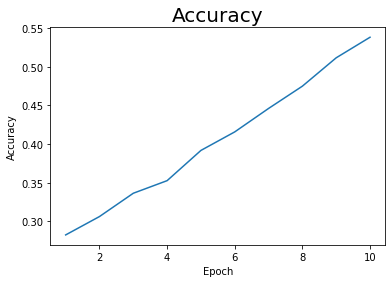

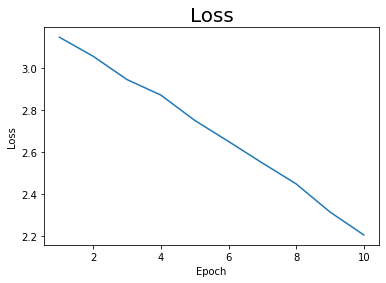

In [164]:
from matplotlib import pyplot as plt

from matplotlib.pyplot import subplots, show

fig, ax = subplots()
ax.plot(range(1, len(accuracy_list)+1), accuracy_list)
ax.set_title('Accuracy', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
show()

fig, ax = subplots()
ax.plot(range(1, len(loss_list) +1), loss_list)
ax.set_title('Loss', fontsize = 20)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
show()

Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

In [151]:
def test_model(model, criterion):
    model.eval()

    # TODO: Implement your testing loop with the `test_loader` data
    accurate_count = 0
    inaccurate_count = 0
    epoch_loss = []

    for data, labels in test_loader:
      data = data.cuda()
      labels = labels.cuda()

      # calculate prediction
      prediction = model(data)

      # calculate loss and loss backward
      loss = criterion(prediction, labels.cuda())
      loss.backward()
      epoch_loss.append(loss.item())

      # calculate the number of accurate prediction
      prediction = torch.argmax(prediction, 1)
      index = 0
      for i in prediction:
        if i == labels[index]:
          accurate_count += 1
        else:
          inaccurate_count +=1
        index += 1

    testing_loss = sum(epoch_loss)/len(epoch_loss)       # TODO: Set this to your testing loss
    testing_accuracy = accurate_count/(accurate_count + inaccurate_count)     # TODO: Set this to your testing accuracy
    return  testing_loss, testing_accuracy


In [152]:
# TODO: Compute performance on the test set
# you may need to write a new function similar to `test_model` but without the flattening aspect
cnn_testing_loss, cnn_testing_accuracy = test_model(cnn_model, criterion)

print("Convolutional Neural Network - the testing loss is ", str(cnn_testing_loss))
print("Convolutional Neural Network - the testing accuracy is ", str(cnn_testing_accuracy))

Convolutional Neural Network - the testing loss is  3.994247981239468
Convolutional Neural Network - the testing accuracy is  0.10885885885885886
